In [10]:
!pip install PyWavelets
!pip install ultralytics
!pip install wandb
!pip install -U ipywidgets

# ============================
# Show Keras and TensorFlow Installation
# ============================
# !pip show keras tensorflow

# ============================
# Clear Output in Notebook
# ============================
from IPython import display
display.clear_output()

In [11]:
import logging
import random
import numpy as np
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from IPython.display import display
import wandb
from ultralytics import YOLO

In [6]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [5]:
import os
from collections import Counter
import glob
import yaml

def analyze_dataset_distribution(yaml_path):
    # Read YAML file
    with open(yaml_path, 'r') as file:
        data = yaml.safe_load(file)
    
    # Get paths to label files
    train_labels = glob.glob(os.path.join(data['train'].replace('images', 'labels'), '*.txt'))
    val_labels = glob.glob(os.path.join(data['val'].replace('images', 'labels'), '*.txt'))
    
    class_counts = Counter()
    total_instances = 0
    
    # Count instances per class
    for label_file in train_labels + val_labels:
        with open(label_file, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                class_counts[class_id] += 1
                total_instances += 1
    
    # Print distribution
    print("\nClass Distribution:")
    print("-" * 50)
    for class_id, count in sorted(class_counts.items()):
        class_name = data['names'][class_id]
        percentage = (count / total_instances) * 100
        print(f"Class {class_id} ({class_name}): {count} instances ({percentage:.2f}%)")
    
    return class_counts

# Use your data.yaml path
distribution = analyze_dataset_distribution('/kaggle/input/dataset-neuroscan/TumorDetectionYolov8/data.yaml')


Class Distribution:
--------------------------------------------------
Class 0 (Glioma): 5459 instances (28.21%)
Class 1 (Meningioma): 8682 instances (44.86%)
Class 2 (Pituitary): 5211 instances (26.93%)


In [16]:
post_training_files_path = '/kaggle/working/Brain-Tumor-Detection/yolov8_brain_tumor_detection'

# Construct the path to the best model weights file using os.path.join
best_model_path = '/kaggle/working/runs/detect/train/weights/best.pt'
# Load the best model weights into the YOLO model
best_model = YOLO(best_model_path)

# Validate the best model using the validation set with default parameters
metrics = best_model.val(split='val')

Ultralytics 8.3.31 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /kaggle/input/dataset-neuroscan/TumorDetectionYolov8/valid/labels... 990 images, 15 backgrounds, 0 corrupt: 100%|██████████| 990/990 [00:01<00:00, 695.34it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/dataset-neuroscan/TumorDetectionYolov8/valid is not writeable, cache not saved.


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:05<00:00, 11.49it/s]


                   all        990       2141      0.915      0.783      0.839      0.618
                Glioma        608        608      0.896      0.719      0.795      0.538
            Meningioma        960        960      0.948      0.873      0.908      0.733
             Pituitary        573        573      0.901      0.757      0.813      0.584
Speed: 0.0ms preprocess, 1.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val


In [ ]:
def train_yolo_model(
    data_yaml,
    epochs=200,
    batch_size=64,
    img_size=160,
    existing_model_path='/kaggle/input/bestneuroscan/pytorch/default/1/best.pt',
    initial_lr=1e-5,
    lrf=0.01 
):
    try:
        # Load the model from the checkpoint
        model = YOLO(existing_model_path)

        # Train with fine-tuning adjustments, including learning rate decay
        training_results = model.train(
            data=data_yaml,
            epochs=epochs,
            batch=batch_size,
            imgsz=img_size,
            device=0 if torch.cuda.is_available() else 'cpu',
            optimizer='Adam',
            lr0=initial_lr,
            lrf=lrf,
            verbose=True,
            
            # Early stopping and fine-tuning parameters
            momentum=0.937,
            weight_decay=0.0005,
            patience=50,
            augment=True,
            mosaic=0.5,
            mixup=0.1,
        )

        # Load the top-performing model after fine-tuning
        optimal_model_path = training_results.best_model_path
        model = YOLO(optimal_model_path)

        return model

    except Exception as e:
        print(f"Error during YOLOv8 training: {str(e)}")
        return None

# Training call
data_yaml_path = '/kaggle/input/dataset-neuroscan/TumorDetectionYolov8/data.yaml'
trained_model = train_yolo_model(
    data_yaml=data_yaml_path,
    epochs=200,
    batch_size=80,
    img_size=160,
    existing_model_path='/kaggle/input/bestneuroscan/pytorch/default/1/best.pt',
    initial_lr=1e-5,
    lrf=0.01
)


Ultralytics 8.3.31 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/bestneuroscan/pytorch/default/1/best.pt, data=/kaggle/input/dataset-neuroscan/TumorDetectionYolov8/data.yaml, epochs=200, time=None, patience=50, batch=80, imgsz=160, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf

100%|██████████| 755k/755k [00:00<00:00, 14.0MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

100%|██████████| 5.35M/5.35M [00:00<00:00, 61.3MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/dataset-neuroscan/TumorDetectionYolov8/train/labels... 7920 images, 88 backgrounds, 0 corrupt: 100%|██████████| 7920/7920 [00:40<00:00, 197.99it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/dataset-neuroscan/TumorDetectionYolov8/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/dataset-neuroscan/TumorDetectionYolov8/valid/labels... 990 images, 15 backgrounds, 0 corrupt: 100%|██████████| 990/990 [00:04<00:00, 199.11it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/dataset-neuroscan/TumorDetectionYolov8/valid is not writeable, cache not saved.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=1e-05, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000625), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 160 train, 160 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      1.43G      1.285     0.8223      1.235        254        160: 100%|██████████| 99/99 [00:17<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]

                   all        990       2141      0.852      0.697      0.757      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      1.33G      1.223     0.7759      1.201        259        160: 100%|██████████| 99/99 [00:15<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.915      0.746      0.819      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      1.42G      1.178     0.7479      1.179        237        160: 100%|██████████| 99/99 [00:15<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.936      0.741      0.822      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      1.37G      1.155     0.7233      1.167        275        160: 100%|██████████| 99/99 [00:15<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        990       2141      0.921      0.754      0.826       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      1.33G      1.152      0.727      1.164        233        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        990       2141      0.913      0.759      0.827      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      1.32G       1.15     0.7233      1.167        282        160: 100%|██████████| 99/99 [00:15<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.923      0.758      0.828      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      1.33G       1.14     0.7117      1.159        295        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        990       2141       0.92      0.761       0.83      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200       1.4G      1.143     0.7183      1.166        240        160: 100%|██████████| 99/99 [00:15<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        990       2141      0.916      0.761      0.828      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      1.38G      1.135     0.7119      1.159        260        160: 100%|██████████| 99/99 [00:15<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        990       2141      0.921      0.759      0.829      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      1.33G      1.131      0.708      1.153        229        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        990       2141      0.922      0.757      0.829      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      1.33G      1.138     0.7081      1.158        299        160: 100%|██████████| 99/99 [00:15<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        990       2141      0.914      0.758      0.827      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      1.33G      1.127     0.7038      1.152        264        160: 100%|██████████| 99/99 [00:15<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        990       2141      0.919      0.757      0.827      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      1.32G      1.127     0.7063      1.151        271        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.919      0.759       0.83      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      1.32G      1.135     0.7076      1.155        262        160: 100%|██████████| 99/99 [00:16<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        990       2141      0.913      0.762       0.83      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      1.33G      1.122     0.7021      1.149        258        160: 100%|██████████| 99/99 [00:15<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.916      0.761      0.832      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      1.33G      1.129     0.6987      1.154        270        160: 100%|██████████| 99/99 [00:15<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        990       2141      0.915      0.763      0.832      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      1.32G      1.126     0.7059      1.147        267        160: 100%|██████████| 99/99 [00:15<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.917      0.762      0.832        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      1.33G      1.122     0.7066      1.151        261        160: 100%|██████████| 99/99 [00:15<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.918      0.763      0.834      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      1.38G      1.109     0.6859      1.143        273        160: 100%|██████████| 99/99 [00:15<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        990       2141      0.918       0.76      0.833      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      1.42G      1.112     0.6983      1.145        310        160: 100%|██████████| 99/99 [00:15<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.931      0.755      0.834      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      1.33G      1.105      0.695      1.146        267        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.931      0.757      0.833      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      1.47G      1.116     0.7025      1.146        262        160: 100%|██████████| 99/99 [00:15<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        990       2141      0.925      0.758      0.832      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      1.38G      1.111     0.6933      1.144        256        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.924      0.759      0.832      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      1.33G      1.096      0.685      1.139        268        160: 100%|██████████| 99/99 [00:15<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.926      0.759      0.833      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      1.33G       1.11      0.695      1.141        274        160: 100%|██████████| 99/99 [00:15<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

                   all        990       2141      0.925      0.763      0.834      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      1.33G      1.103     0.6901      1.139        252        160: 100%|██████████| 99/99 [00:15<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.919      0.768      0.835      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      1.33G       1.11     0.6856      1.139        269        160: 100%|██████████| 99/99 [00:15<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        990       2141      0.904      0.779      0.834      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      1.41G       1.11     0.6907      1.144        277        160: 100%|██████████| 99/99 [00:15<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        990       2141      0.911      0.772      0.836      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      1.33G      1.099     0.6898       1.14        317        160: 100%|██████████| 99/99 [00:15<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.917       0.77      0.834      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      1.32G      1.101     0.6884      1.141        301        160: 100%|██████████| 99/99 [00:15<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141       0.92      0.766      0.835      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      1.33G      1.099     0.6855      1.135        235        160: 100%|██████████| 99/99 [00:15<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.908      0.775      0.835      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      1.38G      1.092     0.6809      1.135        228        160: 100%|██████████| 99/99 [00:15<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        990       2141      0.907      0.774      0.835      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      1.47G      1.089     0.6808      1.137        268        160: 100%|██████████| 99/99 [00:15<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        990       2141       0.91      0.769      0.835      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      1.47G      1.089      0.679      1.134        245        160: 100%|██████████| 99/99 [00:15<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        990       2141      0.918      0.769      0.835      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      1.33G      1.095     0.6811      1.136        263        160: 100%|██████████| 99/99 [00:16<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.915      0.768      0.834      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      1.33G      1.098     0.6829      1.138        262        160: 100%|██████████| 99/99 [00:15<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        990       2141      0.913      0.772      0.835      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      1.41G      1.098     0.6816      1.136        301        160: 100%|██████████| 99/99 [00:15<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        990       2141      0.918      0.773      0.836      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      1.38G      1.096     0.6811      1.136        260        160: 100%|██████████| 99/99 [00:15<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.927      0.765      0.835      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      1.41G      1.093     0.6846      1.136        238        160: 100%|██████████| 99/99 [00:15<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        990       2141      0.925      0.765      0.835      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      1.38G      1.092     0.6786      1.134        268        160: 100%|██████████| 99/99 [00:16<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        990       2141      0.925      0.767      0.836      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      1.47G      1.088     0.6767      1.133        265        160: 100%|██████████| 99/99 [00:15<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        990       2141      0.923      0.772      0.836      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      1.41G      1.087     0.6796      1.131        271        160: 100%|██████████| 99/99 [00:15<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.923      0.768      0.836      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      1.33G      1.092     0.6753      1.137        246        160: 100%|██████████| 99/99 [00:15<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.927      0.767      0.836      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      1.47G      1.081     0.6755      1.132        256        160: 100%|██████████| 99/99 [00:15<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.905      0.782      0.837      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      1.33G      1.083     0.6823      1.127        263        160: 100%|██████████| 99/99 [00:15<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        990       2141      0.909      0.781      0.837      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      1.47G      1.079     0.6752      1.126        255        160: 100%|██████████| 99/99 [00:15<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141       0.93      0.761      0.837      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      1.33G       1.08     0.6741      1.128        259        160: 100%|██████████| 99/99 [00:15<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        990       2141      0.929      0.761      0.835      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      1.47G      1.089     0.6761      1.133        267        160: 100%|██████████| 99/99 [00:15<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.928      0.762      0.836       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      1.41G      1.087     0.6835      1.131        260        160: 100%|██████████| 99/99 [00:15<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        990       2141      0.927      0.764      0.837      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      1.47G      1.069     0.6667      1.121        261        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        990       2141      0.926       0.76      0.835       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      1.33G      1.071     0.6626      1.123        254        160: 100%|██████████| 99/99 [00:15<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        990       2141      0.924      0.767      0.835       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      1.47G      1.077     0.6755      1.129        268        160: 100%|██████████| 99/99 [00:15<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.926      0.766      0.837      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      1.32G      1.083     0.6746      1.133        273        160: 100%|██████████| 99/99 [00:15<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        990       2141      0.911      0.778      0.837      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      1.47G      1.084     0.6744      1.135        235        160: 100%|██████████| 99/99 [00:15<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        990       2141      0.909      0.777      0.835      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      1.33G      1.073     0.6649      1.126        253        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        990       2141      0.912      0.776      0.836      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      1.33G      1.075     0.6758      1.126        244        160: 100%|██████████| 99/99 [00:15<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        990       2141       0.91      0.774      0.836       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      1.33G      1.076     0.6695      1.126        270        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        990       2141      0.908      0.776      0.837      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      1.42G       1.08     0.6703      1.128        271        160: 100%|██████████| 99/99 [00:15<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        990       2141      0.903      0.783      0.837       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      1.47G      1.073     0.6653      1.125        253        160: 100%|██████████| 99/99 [00:15<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        990       2141      0.902      0.785      0.837      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      1.32G      1.068     0.6628      1.124        254        160: 100%|██████████| 99/99 [00:15<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        990       2141      0.905      0.784      0.838      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      1.48G      1.077     0.6756      1.126        256        160: 100%|██████████| 99/99 [00:15<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.912      0.785      0.838      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      1.47G      1.062     0.6588       1.12        225        160: 100%|██████████| 99/99 [00:15<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        990       2141       0.91      0.785      0.836      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      1.41G      1.072     0.6681      1.127        248        160: 100%|██████████| 99/99 [00:15<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.914      0.785      0.838      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      1.38G      1.071     0.6628      1.126        221        160: 100%|██████████| 99/99 [00:15<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        990       2141      0.913      0.783      0.838      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      1.41G      1.076     0.6734      1.127        231        160: 100%|██████████| 99/99 [00:15<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        990       2141      0.908      0.783      0.838      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      1.38G      1.071     0.6641      1.121        276        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        990       2141       0.91      0.784      0.839      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      1.33G       1.07     0.6652      1.119        267        160: 100%|██████████| 99/99 [00:15<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.908      0.781      0.838      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      1.41G      1.075     0.6687      1.126        234        160: 100%|██████████| 99/99 [00:15<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        990       2141      0.911      0.781      0.838      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      1.33G       1.06     0.6564      1.117        253        160: 100%|██████████| 99/99 [00:15<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        990       2141      0.908      0.785      0.838      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      1.33G      1.063     0.6576      1.116        262        160: 100%|██████████| 99/99 [00:15<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        990       2141      0.915      0.783      0.837      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      1.32G      1.069     0.6609      1.122        257        160: 100%|██████████| 99/99 [00:15<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.914      0.784      0.837      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      1.38G      1.066     0.6622      1.123        263        160: 100%|██████████| 99/99 [00:15<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        990       2141      0.907      0.783      0.838      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      1.42G      1.073     0.6647      1.128        250        160: 100%|██████████| 99/99 [00:15<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        990       2141       0.91      0.784      0.837      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      1.32G      1.062      0.662      1.122        278        160: 100%|██████████| 99/99 [00:15<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]

                   all        990       2141      0.916      0.781      0.837      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      1.33G      1.067     0.6628      1.122        270        160: 100%|██████████| 99/99 [00:15<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        990       2141      0.913      0.785      0.837      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      1.33G      1.068     0.6636      1.119        282        160: 100%|██████████| 99/99 [00:15<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141       0.91      0.786      0.837      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      1.47G      1.061     0.6662      1.118        259        160: 100%|██████████| 99/99 [00:15<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.913      0.786      0.838      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      1.33G      1.068     0.6659       1.12        256        160: 100%|██████████| 99/99 [00:15<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        990       2141      0.919      0.782      0.839      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      1.41G       1.05     0.6517      1.113        228        160: 100%|██████████| 99/99 [00:15<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        990       2141      0.911      0.784      0.839      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      1.33G      1.058     0.6609      1.119        247        160: 100%|██████████| 99/99 [00:15<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        990       2141      0.907      0.785      0.838      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      1.33G      1.057     0.6622      1.118        232        160: 100%|██████████| 99/99 [00:15<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.909      0.785      0.839      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      1.33G      1.073     0.6658      1.122        274        160: 100%|██████████| 99/99 [00:15<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        990       2141      0.906      0.787      0.838      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      1.32G      1.061     0.6643      1.119        267        160: 100%|██████████| 99/99 [00:15<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        990       2141       0.91      0.783      0.838      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      1.47G      1.059     0.6612      1.118        253        160: 100%|██████████| 99/99 [00:15<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.911      0.783      0.838      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      1.33G      1.057     0.6542      1.116        279        160: 100%|██████████| 99/99 [00:15<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        990       2141      0.912      0.784      0.838      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      1.33G      1.057     0.6599      1.117        224        160: 100%|██████████| 99/99 [00:15<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.913      0.784      0.838      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      1.33G       1.06     0.6566      1.114        254        160: 100%|██████████| 99/99 [00:15<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.914      0.784      0.838      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      1.41G      1.058     0.6644      1.121        268        160: 100%|██████████| 99/99 [00:15<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        990       2141       0.91      0.784      0.839      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      1.34G      1.055     0.6641      1.119        233        160: 100%|██████████| 99/99 [00:15<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.909      0.784      0.839      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      1.34G      1.062     0.6574      1.117        265        160: 100%|██████████| 99/99 [00:15<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.906      0.783      0.838      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      1.32G      1.057     0.6572      1.116        266        160: 100%|██████████| 99/99 [00:15<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        990       2141      0.906      0.783      0.839      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      1.33G      1.052     0.6575      1.118        262        160: 100%|██████████| 99/99 [00:15<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        990       2141      0.907      0.783      0.838      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      1.33G      1.056     0.6625      1.116        232        160: 100%|██████████| 99/99 [00:15<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        990       2141      0.908      0.782      0.838      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      1.33G      1.049     0.6572      1.114        220        160: 100%|██████████| 99/99 [00:15<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        990       2141      0.925      0.771      0.839      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      1.32G      1.046     0.6481      1.114        268        160: 100%|██████████| 99/99 [00:15<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        990       2141      0.911      0.783      0.838      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      1.47G      1.052     0.6573      1.117        220        160: 100%|██████████| 99/99 [00:15<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        990       2141      0.909      0.784      0.839      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      1.38G      1.052     0.6525      1.111        235        160: 100%|██████████| 99/99 [00:15<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        990       2141      0.929       0.77      0.839      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      1.47G      1.053     0.6577      1.115        262        160: 100%|██████████| 99/99 [00:15<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.915       0.78      0.839      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      1.38G      1.048      0.652       1.11        233        160: 100%|██████████| 99/99 [00:15<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        990       2141      0.912      0.782      0.839      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      1.33G      1.056     0.6582      1.117        253        160: 100%|██████████| 99/99 [00:15<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        990       2141      0.929      0.773      0.839      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      1.37G      1.058     0.6634      1.118        236        160: 100%|██████████| 99/99 [00:15<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.928      0.773      0.839      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      1.33G      1.047     0.6523      1.111        258        160: 100%|██████████| 99/99 [00:15<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        990       2141      0.914      0.784      0.838      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      1.33G      1.048     0.6525      1.116        275        160: 100%|██████████| 99/99 [00:15<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.927      0.774      0.838      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      1.32G      1.041     0.6472       1.11        263        160: 100%|██████████| 99/99 [00:15<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141       0.91      0.783      0.838      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      1.32G      1.064     0.6661      1.121        285        160: 100%|██████████| 99/99 [00:15<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.919      0.776      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      1.33G      1.062     0.6603      1.123        222        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.911      0.786      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      1.41G      1.055      0.658      1.112        245        160: 100%|██████████| 99/99 [00:15<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.911      0.786      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      1.33G      1.045     0.6517       1.11        229        160: 100%|██████████| 99/99 [00:15<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.909      0.786      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      1.32G      1.053     0.6562      1.118        214        160: 100%|██████████| 99/99 [00:15<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        990       2141      0.912      0.784      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      1.32G      1.047     0.6555      1.112        275        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        990       2141      0.913      0.785       0.84      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      1.38G      1.043     0.6516      1.112        232        160: 100%|██████████| 99/99 [00:15<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        990       2141      0.914      0.784      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      1.47G      1.056     0.6555      1.116        257        160: 100%|██████████| 99/99 [00:15<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        990       2141      0.914      0.784      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      1.47G       1.06     0.6599      1.123        266        160: 100%|██████████| 99/99 [00:15<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.913      0.784       0.84      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      1.33G       1.04     0.6416      1.106        267        160: 100%|██████████| 99/99 [00:15<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.913      0.784      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      1.32G      1.051     0.6558      1.117        256        160: 100%|██████████| 99/99 [00:15<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        990       2141      0.913      0.784      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      1.41G      1.049     0.6588      1.118        261        160: 100%|██████████| 99/99 [00:15<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        990       2141      0.913      0.785      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      1.38G      1.055     0.6629      1.114        259        160: 100%|██████████| 99/99 [00:15<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        990       2141      0.912      0.784      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      1.41G      1.048     0.6588       1.11        281        160: 100%|██████████| 99/99 [00:15<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        990       2141      0.908      0.784      0.839      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      1.38G       1.05     0.6531      1.114        243        160: 100%|██████████| 99/99 [00:15<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141       0.91      0.784      0.839      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      1.47G      1.041     0.6452      1.107        226        160: 100%|██████████| 99/99 [00:15<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        990       2141       0.91      0.784      0.839      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      1.41G       1.04      0.646      1.105        251        160: 100%|██████████| 99/99 [00:15<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        990       2141      0.909      0.784      0.838      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      1.33G      1.044     0.6476      1.109        266        160: 100%|██████████| 99/99 [00:15<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        990       2141      0.911      0.785      0.839      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      1.48G      1.041     0.6491       1.11        253        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141       0.91      0.784      0.839      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      1.33G      1.042     0.6463       1.11        283        160: 100%|██████████| 99/99 [00:15<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        990       2141       0.91      0.783      0.839      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      1.47G      1.037     0.6448      1.106        258        160: 100%|██████████| 99/99 [00:15<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        990       2141      0.911      0.784      0.839      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      1.32G      1.049      0.647      1.116        230        160: 100%|██████████| 99/99 [00:15<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        990       2141      0.911      0.784      0.839      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      1.47G      1.039     0.6453      1.106        274        160: 100%|██████████| 99/99 [00:15<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        990       2141      0.911      0.784      0.839      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      1.41G      1.051     0.6529      1.115        249        160: 100%|██████████| 99/99 [00:15<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        990       2141      0.912      0.784      0.839      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      1.47G       1.04      0.647      1.108        269        160: 100%|██████████| 99/99 [00:15<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        990       2141      0.913      0.784      0.839      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      1.33G      1.044     0.6497      1.109        288        160: 100%|██████████| 99/99 [00:15<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        990       2141      0.915      0.783      0.839      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      1.47G      1.041     0.6494      1.109        261        160: 100%|██████████| 99/99 [00:15<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.917      0.783      0.839      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      1.32G       1.04     0.6492       1.11        241        160: 100%|██████████| 99/99 [00:15<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        990       2141      0.917      0.783      0.839      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      1.47G      1.038     0.6498      1.112        267        160: 100%|██████████| 99/99 [00:15<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        990       2141      0.916      0.783      0.839      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      1.33G      1.043     0.6502       1.11        264        160: 100%|██████████| 99/99 [00:15<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        990       2141      0.917      0.783      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      1.33G      1.045      0.648      1.108        273        160: 100%|██████████| 99/99 [00:15<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.916      0.783      0.839      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      1.33G      1.042     0.6495      1.114        257        160: 100%|██████████| 99/99 [00:15<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        990       2141      0.918      0.783      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      1.42G      1.047     0.6563      1.112        262        160: 100%|██████████| 99/99 [00:15<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.916      0.783      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      1.47G      1.045     0.6548      1.113        265        160: 100%|██████████| 99/99 [00:15<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        990       2141      0.916      0.783      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      1.32G      1.055     0.6562      1.114        268        160: 100%|██████████| 99/99 [00:15<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.916      0.784      0.839      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      1.47G      1.037     0.6509      1.106        249        160: 100%|██████████| 99/99 [00:15<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        990       2141      0.916      0.784      0.839      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      1.47G      1.039     0.6477      1.111        300        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.915      0.784       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      1.41G      1.041     0.6507       1.11        266        160: 100%|██████████| 99/99 [00:15<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        990       2141      0.916      0.785       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      1.38G      1.048     0.6553      1.113        233        160: 100%|██████████| 99/99 [00:15<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        990       2141      0.916      0.784       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      1.41G      1.047     0.6545      1.115        259        160: 100%|██████████| 99/99 [00:15<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        990       2141      0.916      0.784       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      1.37G      1.039     0.6501      1.106        290        160: 100%|██████████| 99/99 [00:15<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        990       2141      0.916      0.784       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      1.33G      1.034     0.6423      1.106        236        160: 100%|██████████| 99/99 [00:15<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        990       2141      0.916      0.784       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      1.41G      1.034     0.6491      1.105        258        160: 100%|██████████| 99/99 [00:15<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        990       2141      0.916      0.784       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      1.33G      1.031     0.6428      1.105        248        160: 100%|██████████| 99/99 [00:15<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        990       2141      0.915      0.784      0.839      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      1.32G      1.038      0.646      1.111        279        160: 100%|██████████| 99/99 [00:15<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        990       2141      0.916      0.783       0.84      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      1.33G      1.039     0.6486      1.106        300        160: 100%|██████████| 99/99 [00:15<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.915      0.784       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      1.38G      1.046     0.6554       1.11        266        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        990       2141      0.916      0.784       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      1.42G      1.048     0.6548      1.115        219        160: 100%|██████████| 99/99 [00:15<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        990       2141      0.917      0.784       0.84      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      1.32G      1.037     0.6483      1.105        287        160: 100%|██████████| 99/99 [00:15<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        990       2141      0.916      0.783       0.84      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      1.33G      1.041      0.645       1.11        248        160: 100%|██████████| 99/99 [00:15<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        990       2141      0.917      0.784       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      1.41G      1.041     0.6433      1.108        242        160: 100%|██████████| 99/99 [00:15<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        990       2141      0.917      0.783       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      1.33G      1.033     0.6459      1.103        264        160: 100%|██████████| 99/99 [00:15<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        990       2141      0.917      0.783       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      1.33G      1.037     0.6449      1.111        316        160: 100%|██████████| 99/99 [00:15<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        990       2141      0.917      0.783       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      1.33G      1.026     0.6391      1.104        228        160: 100%|██████████| 99/99 [00:16<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        990       2141      0.917      0.782       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      1.32G      1.043     0.6455      1.113        250        160: 100%|██████████| 99/99 [00:15<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.918      0.783       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      1.33G      1.048     0.6494      1.112        280        160: 100%|██████████| 99/99 [00:15<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        990       2141      0.918      0.783      0.841      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      1.32G      1.033      0.637      1.106        256        160: 100%|██████████| 99/99 [00:15<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        990       2141      0.918      0.784       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      1.32G      1.029     0.6402      1.101        289        160: 100%|██████████| 99/99 [00:15<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        990       2141      0.918      0.782       0.84      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      1.33G      1.044     0.6486      1.112        273        160: 100%|██████████| 99/99 [00:15<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        990       2141      0.919      0.782       0.84      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      1.32G      1.042     0.6464      1.108        300        160: 100%|██████████| 99/99 [00:15<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        990       2141      0.918      0.782       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      1.33G      1.037     0.6498       1.11        235        160: 100%|██████████| 99/99 [00:15<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        990       2141      0.918      0.782       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      1.33G      1.024     0.6341      1.103        247        160: 100%|██████████| 99/99 [00:15<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        990       2141      0.918      0.782       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      1.33G      1.048      0.658      1.114        278        160: 100%|██████████| 99/99 [00:15<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        990       2141      0.917      0.783       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      1.38G      1.034     0.6414      1.104        246        160: 100%|██████████| 99/99 [00:15<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        990       2141      0.918      0.782       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      1.32G      1.039     0.6451      1.108        250        160: 100%|██████████| 99/99 [00:15<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        990       2141      0.918      0.782       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      1.32G      1.039     0.6448      1.106        238        160: 100%|██████████| 99/99 [00:15<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.919      0.782       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      1.33G      1.039      0.648      1.106        283        160: 100%|██████████| 99/99 [00:15<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        990       2141      0.919      0.782       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      1.41G      1.034     0.6372      1.105        257        160: 100%|██████████| 99/99 [00:15<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        990       2141      0.922      0.775       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      1.33G      1.038     0.6431      1.108        220        160: 100%|██████████| 99/99 [00:15<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        990       2141       0.92      0.782       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      1.41G      1.038     0.6426      1.109        246        160: 100%|██████████| 99/99 [00:15<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        990       2141      0.922      0.776       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      1.41G      1.032     0.6385      1.102        250        160: 100%|██████████| 99/99 [00:15<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141      0.923      0.776       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      1.33G      1.026     0.6347        1.1        250        160: 100%|██████████| 99/99 [00:15<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        990       2141       0.92      0.778       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      1.33G      1.035     0.6438      1.107        263        160: 100%|██████████| 99/99 [00:15<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        990       2141      0.923      0.777       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      1.32G      1.039     0.6488      1.108        303        160: 100%|██████████| 99/99 [00:15<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        990       2141      0.923      0.777       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      1.47G      1.039     0.6458      1.104        262        160: 100%|██████████| 99/99 [00:15<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        990       2141      0.923      0.778       0.84      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      1.34G       1.04     0.6466      1.109        251        160: 100%|██████████| 99/99 [00:15<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        990       2141      0.921       0.78       0.84      0.618
EarlyStopping: Training stopped early as no improvement observed in last 50 epochs. Best results observed at epoch 130, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



180 epochs completed in 0.994 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.31 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


                   all        990       2141      0.922      0.751      0.829      0.611
                Glioma        608        608      0.922       0.66      0.779       0.53
            Meningioma        960        960      0.953      0.869      0.906      0.732
             Pituitary        573        573      0.892      0.724      0.802      0.571
Speed: 0.0ms preprocess, 1.3ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train
Error during YOLOv8 training: 'DetMetrics' object has no attribute 'best_model_path'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP) of an
    object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func


0: 160x160 1 Glioma, 1 Meningioma, 1 Pituitary, 9.3ms
Speed: 1.8ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 160, 160)

0: 160x160 1 Glioma, 1 Meningioma, 1 Pituitary, 7.2ms
Speed: 0.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 160, 160)

0: 160x160 1 Glioma, 1 Meningioma, 1 Pituitary, 8.0ms
Speed: 0.7ms preprocess, 8.0ms inference, 1.2ms postprocess per image at shape (1, 3, 160, 160)

0: 160x160 (no detections), 7.4ms
Speed: 0.7ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 160, 160)

0: 160x160 (no detections), 7.4ms
Speed: 0.6ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 160, 160)

0: 160x160 1 Glioma, 1 Meningioma, 1 Pituitary, 8.5ms
Speed: 0.6ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 160, 160)

0: 160x160 1 Meningioma, 6.9ms
Speed: 0.6ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 160, 160)

0: 16

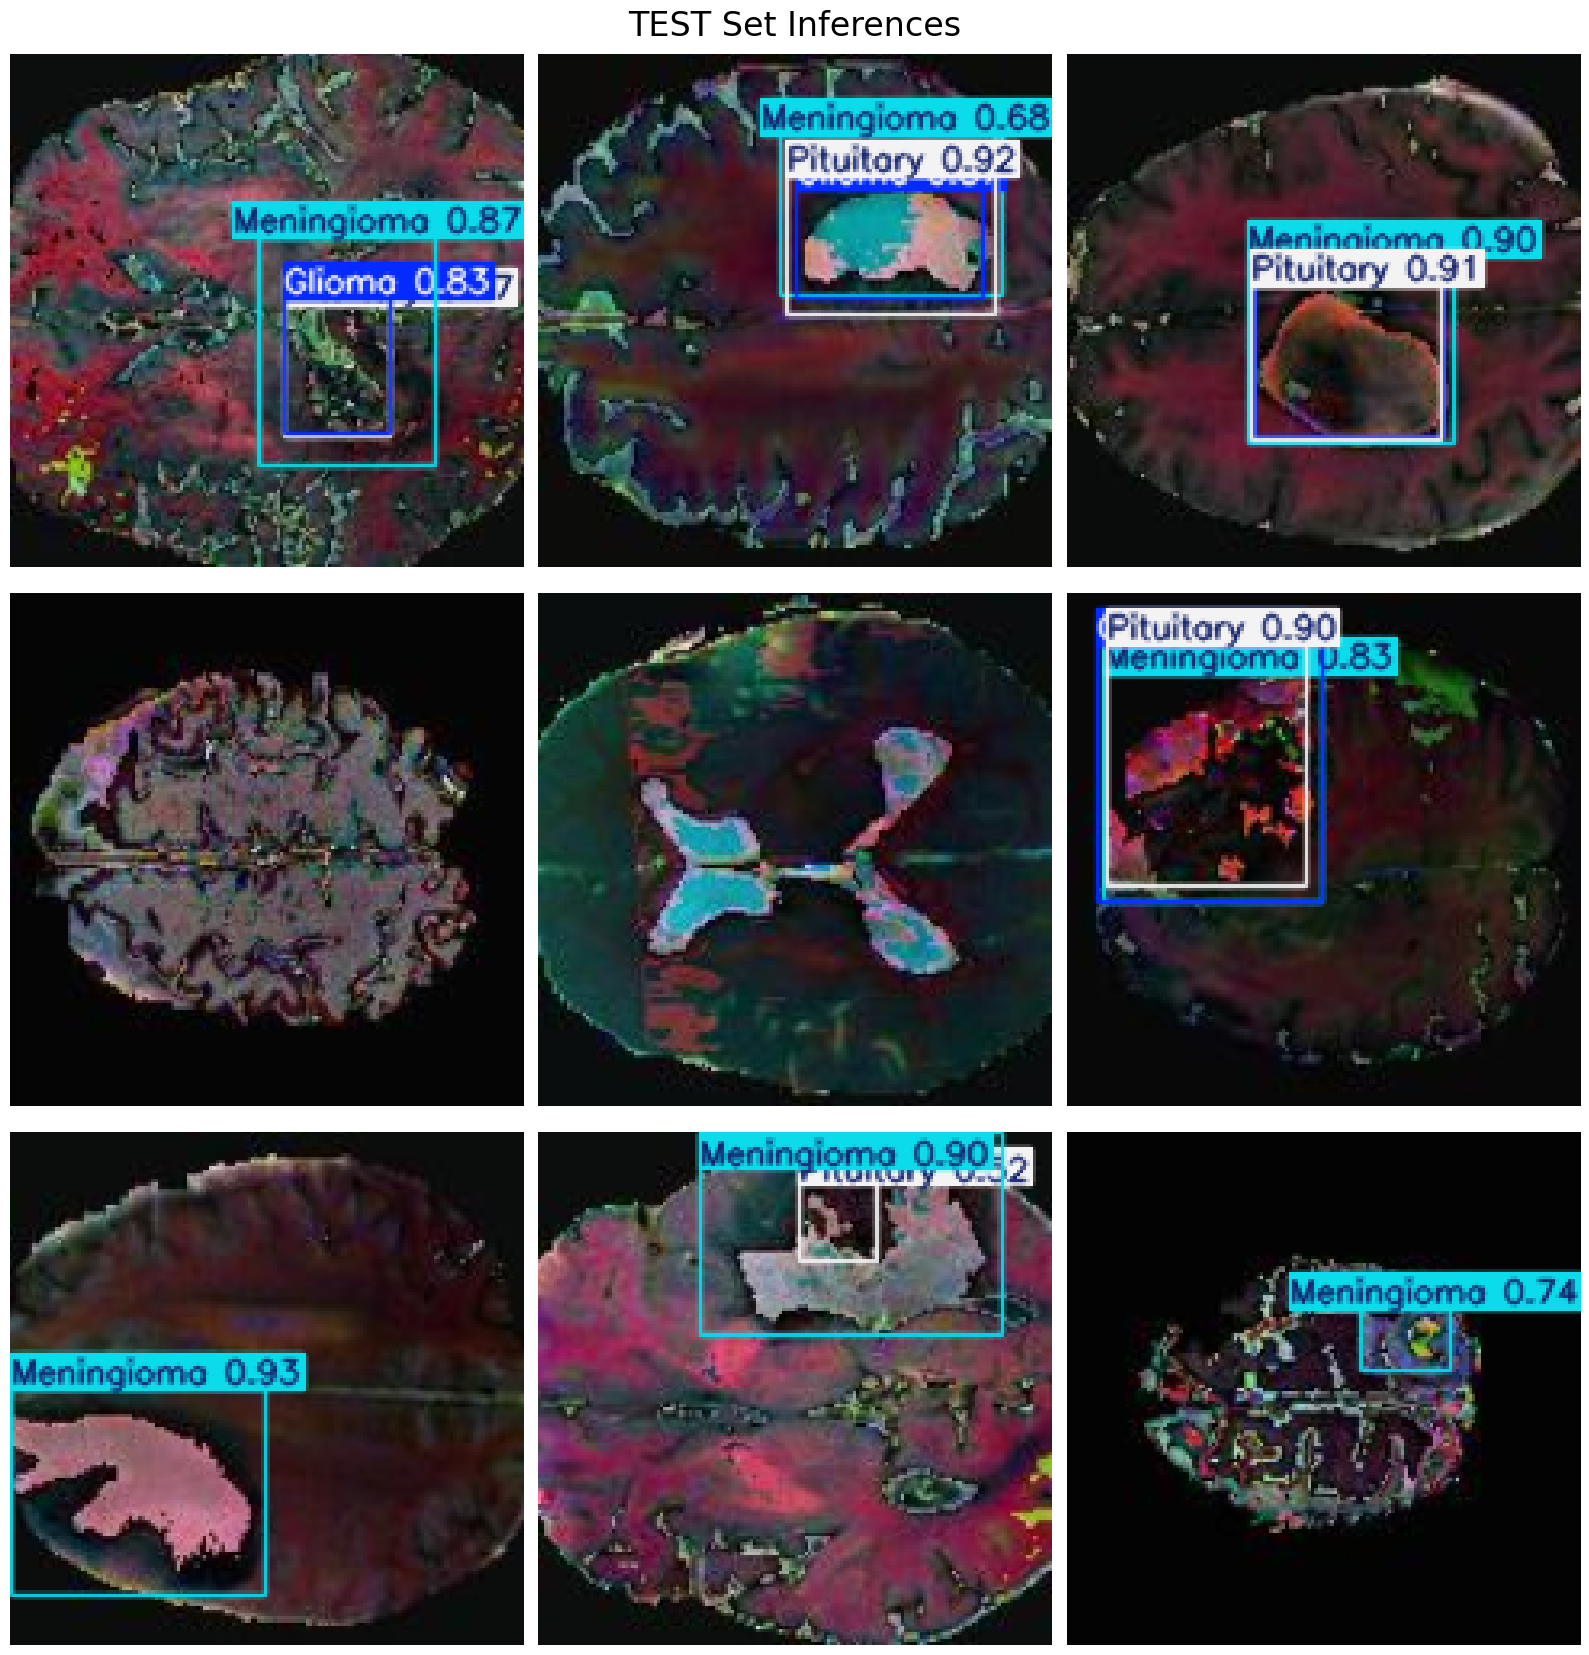

In [17]:
def normalize_image(image):
    return image / 255.0

# Image resizing function
def resize_image(image, size=(160, 160)):
    return cv2.resize(image, size)

# Path to validation images
dataset_path = '/kaggle/input/dataset-neuroscan/TumorDetectionYolov8'  # Place your dataset path here
valid_images_path = os.path.join(dataset_path, 'test', 'images')

# List of all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Check if there are images in the directory
if len(image_files) > 0:
    # Select 9 images at equal intervals
    num_images = len(image_files)
    step_size = max(1, num_images // 9)  # Ensure the interval is at least 1
    selected_images = [image_files[i] for i in range(0, num_images, step_size)]

    # Prepare subplots
    fig, axes = plt.subplots(3, 3, figsize=(16, 17))
    fig.suptitle('TEST Set Inferences', fontsize=24)

    for i, ax in enumerate(axes.flatten()):
        if i < len(selected_images):
            image_path = os.path.join(valid_images_path, selected_images[i])
            
            # Load image
            image = cv2.imread(image_path)
            
            # Check if the image is loaded correctly
            if image is not None:
                # Resize image
                resized_image = resize_image(image, size=(160, 160))
                # Normalize image
                normalized_image = normalize_image(resized_image)
                
                # Convert the normalized image to uint8 data type
                normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)
                
                # Predict with the model
                results = best_model.predict(source=normalized_image_uint8, imgsz=160, conf=0.5)
                
                # Plot image with labels
                annotated_image = results[0].plot(line_width=1)
                annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
                ax.imshow(annotated_image_rgb)
            else:
                print(f"Failed to load image {image_path}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Load the fine-tuned model
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

# Path to the test data
test_data_path = "/kaggle/input/dataset-neuroscan/TumorDetectionYolov8/data.yaml"

# Run validation on the test data
results = model.val(
    data=test_data_path,  # Path to the test dataset YAML or folder with test images
    imgsz=160,            # Image size (same as used in training)
    batch=32,             # Batch size
    device=0              # Device to run evaluation on
)

# Print the main metrics
print("Test Results:")
print(f"mAP@0.5: {results.box.map50 * 100:.2f}%")       # mAP at IoU=0.5
print(f"mAP@0.5:0.95: {results.box.map * 100:.2f}%")    # mAP across IoU=0.5:0.95
print(f"Precision: {results.box.mp * 100:.2f}%")
print(f"Recall: {results.box.mr * 100:.2f}%")

# Calculate estimated accuracy based on precision and recall
precision = results.box.mp
recall = results.box.mr
# F1 Score for a rough estimate of accuracy
accuracy = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  
print(f"Estimated Detection Accuracy: {accuracy * 100:.2f}%")

# Optional: Additional metrics can be printed if necessary
print("Class-wise Results:")
for i, name in enumerate(results.names):
    ap50 = results.box.ap50[i] if i < len(results.box.ap50) else 0
    ap = results.box.ap[i] if i < len(results.box.ap) else 0
    print(f"{name}: AP@0.5: {ap50 * 100:.2f}%, AP@0.5:0.95: {ap * 100:.2f}%")


Ultralytics 8.3.31 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /kaggle/input/dataset-neuroscan/TumorDetectionYolov8/valid/labels... 990 images, 15 backgrounds, 0 corrupt: 100%|██████████| 990/990 [00:01<00:00, 751.14it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/dataset-neuroscan/TumorDetectionYolov8/valid is not writeable, cache not saved.


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.90it/s]


                   all        990       2141      0.915      0.783      0.839      0.618
                Glioma        608        608      0.896      0.719      0.795      0.538
            Meningioma        960        960      0.948      0.873      0.908      0.733
             Pituitary        573        573      0.901      0.757      0.813      0.584
Speed: 0.0ms preprocess, 1.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val2
Test Results:
mAP@0.5: 83.87%
mAP@0.5:0.95: 61.82%
Precision: 91.49%
Recall: 78.31%
Estimated Detection Accuracy: 84.39%
Class-wise Results:
0: AP@0.5: 79.52%, AP@0.5:0.95: 53.79%
1: AP@0.5: 90.75%, AP@0.5:0.95: 73.29%
2: AP@0.5: 81.34%, AP@0.5:0.95: 58.37%


In [22]:

# Define a function to plot learning curves for loss values
def plot_learning_curve(df, train_loss_col, val_loss_col, title):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='#141140', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='orangered', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

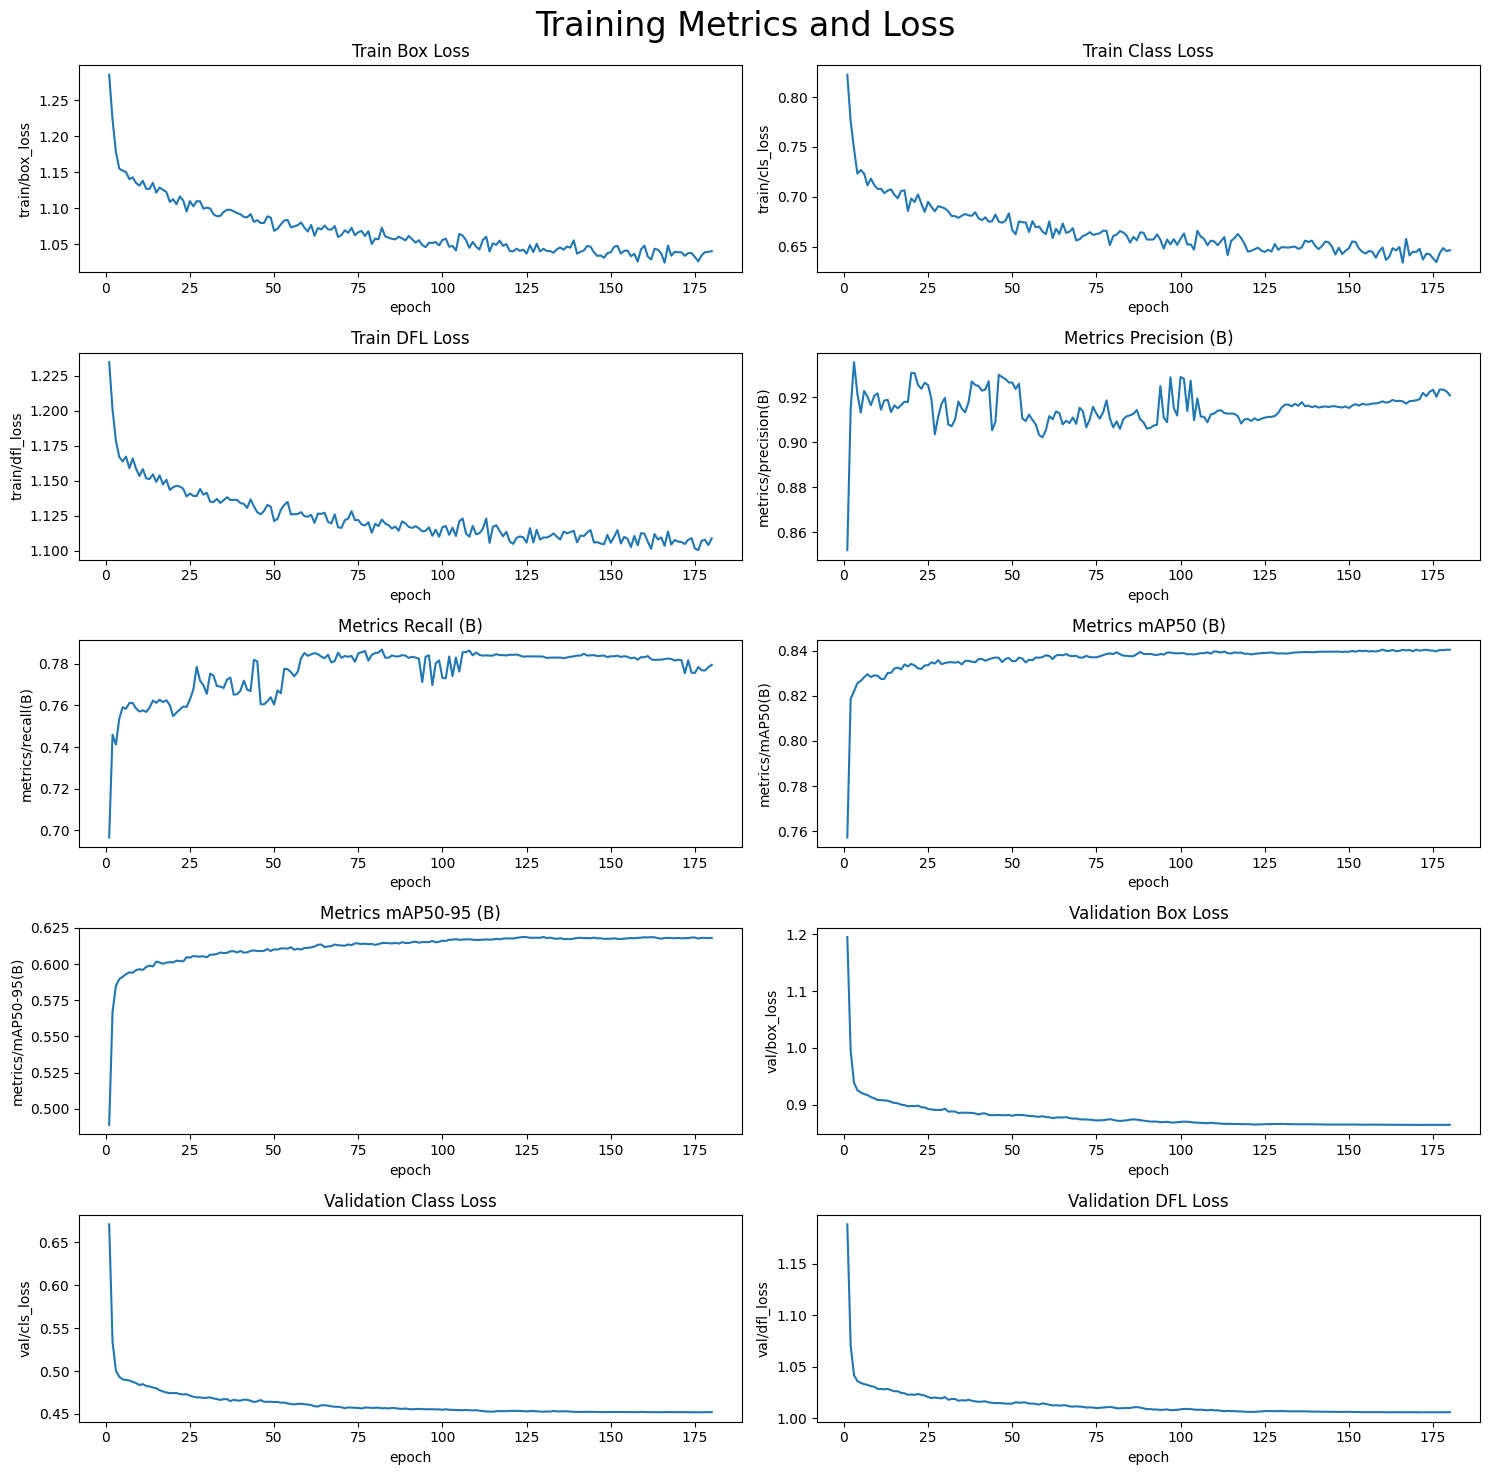

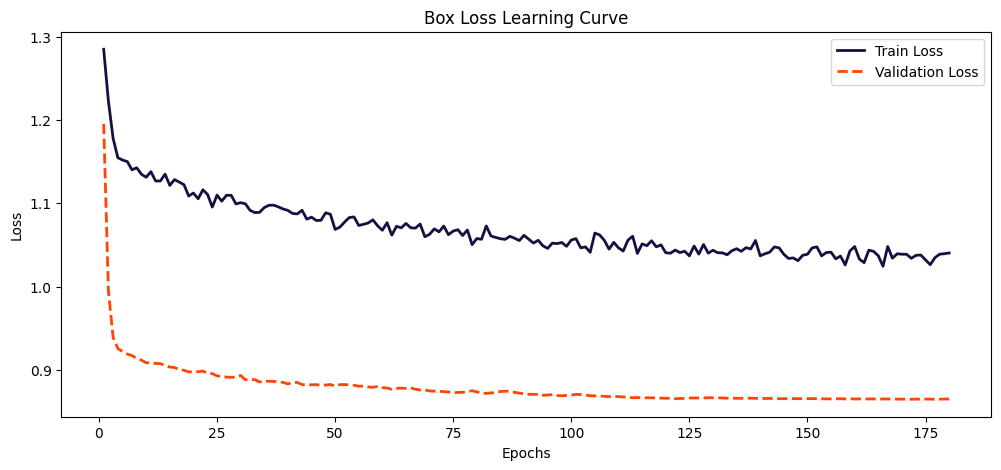

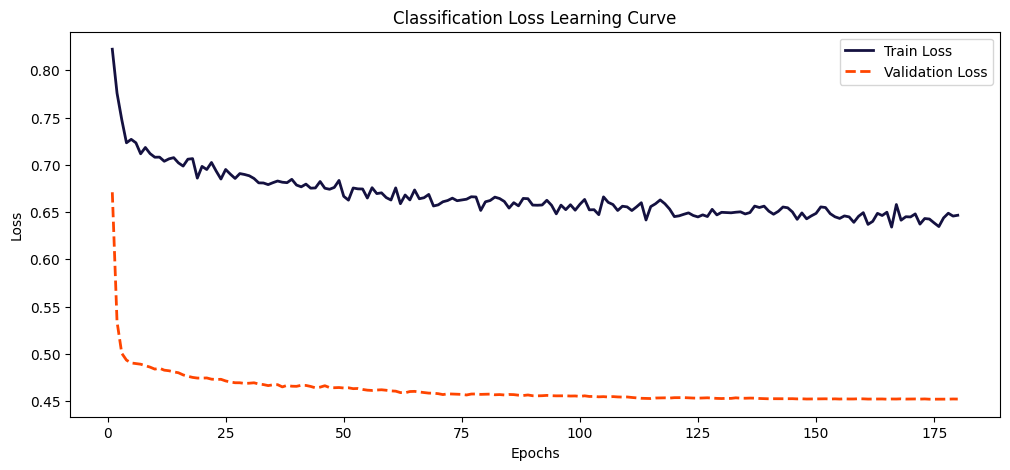

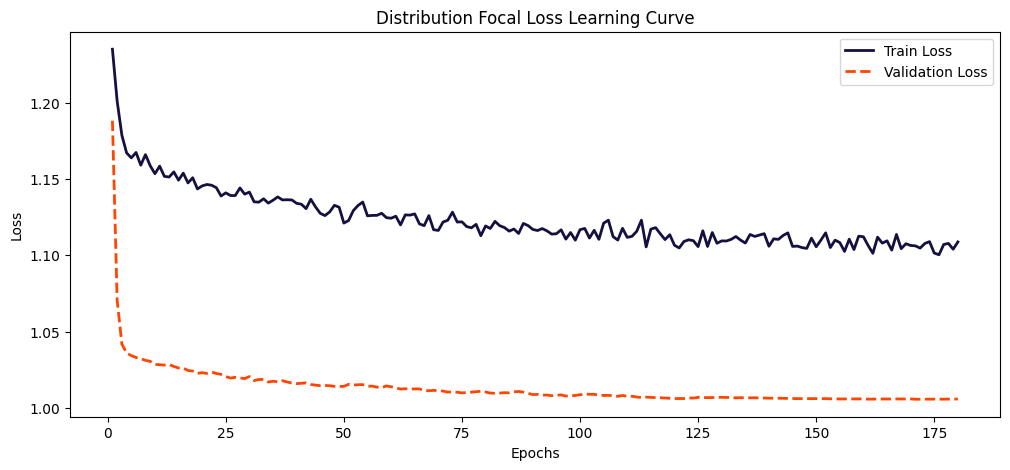

In [23]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/train/results.csv')

df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Remove any leading whitespace from the column names
df.columns = df.columns.str.strip()

# Plot the learning curves for each loss
plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Box Loss Learning Curve')
plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')
plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss Learning Curve')

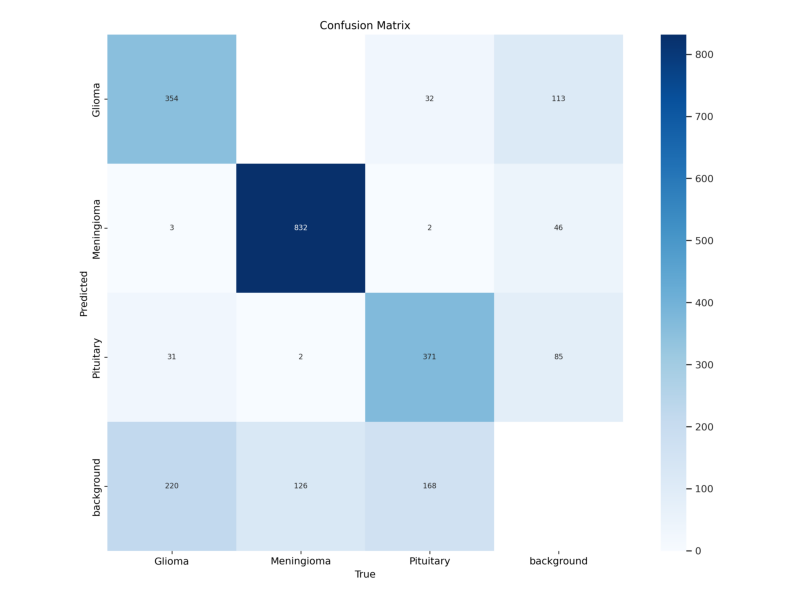

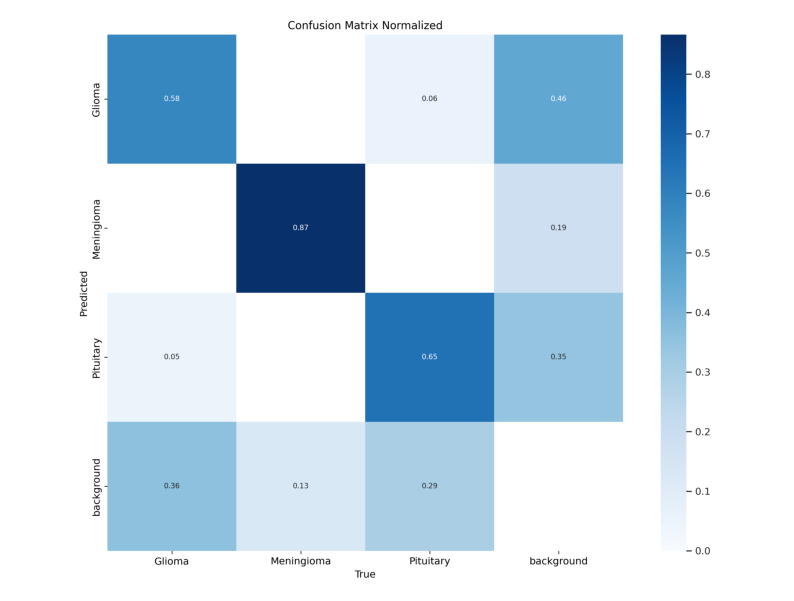

In [26]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/val/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (10, 10))

ax.imshow(img)
ax.axis('off');

# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/val/confusion_matrix_normalized.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (10, 10))

ax.imshow(img)
ax.axis('off');

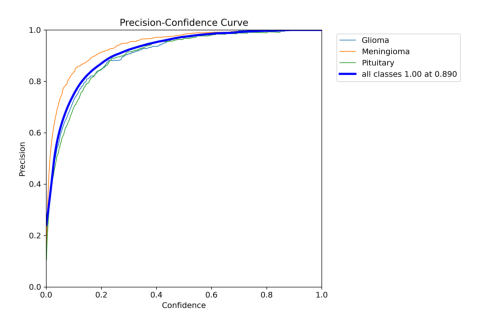

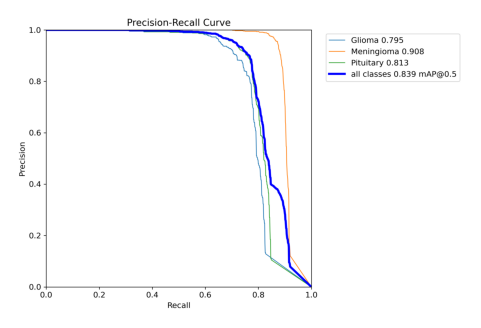

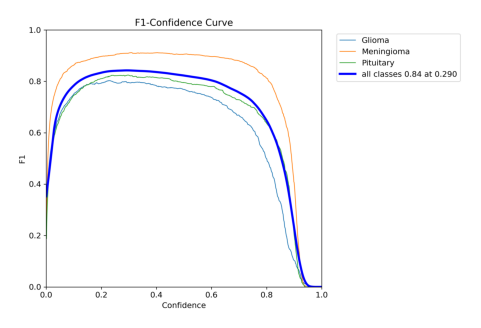

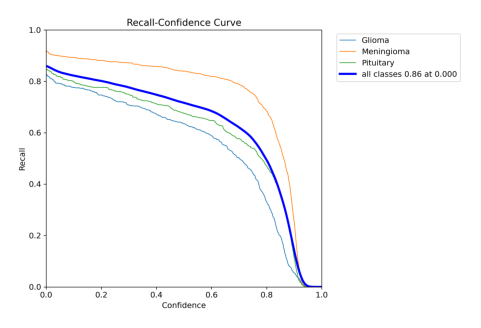

In [27]:
%matplotlib inline


# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/val2/P_curve.png')
fig, ax = plt.subplots(figsize = (18, 4))
ax.imshow(img)
ax.axis('off');


# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/val/PR_curve.png')
fig, ax = plt.subplots(figsize = (18, 4))
ax.imshow(img)
ax.axis('off');

# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/val/F1_curve.png')
fig, ax = plt.subplots(figsize = (18,4))
ax.imshow(img)
ax.axis('off');

# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/val2/R_curve.png')
fig, ax = plt.subplots(figsize = (18,4))
ax.imshow(img)
ax.axis('off');


image 1/1 /kaggle/input/dataset-neuroscan/TumorDetectionYolov8/test/images/volume_323_slice_49_jpg.rf.e017869d30439bc449127cde3d80d44a.jpg: 160x160 1 Glioma, 1 Meningioma, 7.6ms
Speed: 0.5ms preprocess, 7.6ms inference, 2.4ms postprocess per image at shape (1, 3, 160, 160)

image 1/1 /kaggle/input/dataset-neuroscan/TumorDetectionYolov8/test/images/volume_156_slice_51_jpg.rf.9fe09b73fd2a99e4e0ba2ffbba096b46.jpg: 160x160 1 Glioma, 1 Meningioma, 1 Pituitary, 12.0ms
Speed: 0.7ms preprocess, 12.0ms inference, 2.5ms postprocess per image at shape (1, 3, 160, 160)

image 1/1 /kaggle/input/dataset-neuroscan/TumorDetectionYolov8/test/images/volume_330_slice_69_jpg.rf.d6fa7107330ae23464bc9718d37d16b8.jpg: 160x160 1 Glioma, 1 Meningioma, 12.3ms
Speed: 0.7ms preprocess, 12.3ms inference, 2.4ms postprocess per image at shape (1, 3, 160, 160)

image 1/1 /kaggle/input/dataset-neuroscan/TumorDetectionYolov8/test/images/volume_75_slice_90_jpg.rf.b7ae4fc95abf74bdd4105595abaae832.jpg: 160x160 1 Glioma, 

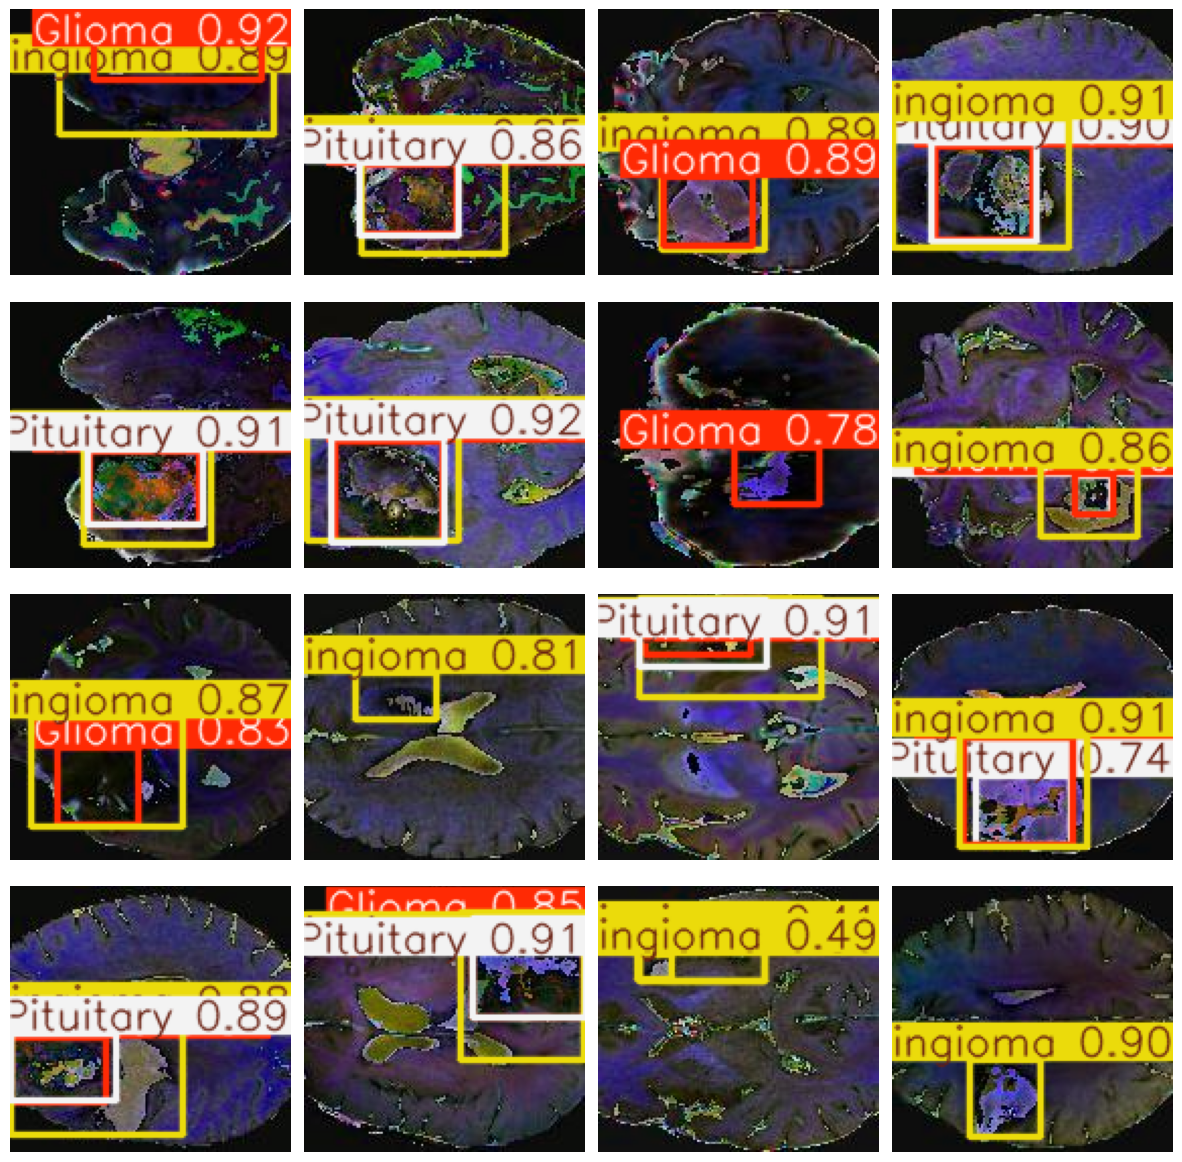

In [28]:
# Load your trained YOLO model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Define the directory where the custom images are stored
custom_image_dir = '/kaggle/input/dataset-neuroscan/TumorDetectionYolov8/test/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    
    # Run detection on the image using your YOLO model
    results = model(img_path)
    
    # Get the detected image with bounding boxes
    detect_img = results[0].plot()  # Or use 'results.show()' if you want to display directly
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()


In [30]:
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Predict with the model
results = model('/kaggle/input/dataset-neuroscan/TumorDetectionYolov8/test/images/volume_107_slice_105_jpg.rf.4a15ce6e7d36d24d1d835db28348336d.jpg')


image 1/1 /kaggle/input/dataset-neuroscan/TumorDetectionYolov8/test/images/volume_107_slice_105_jpg.rf.4a15ce6e7d36d24d1d835db28348336d.jpg: 160x160 1 Meningioma, 9.6ms
Speed: 0.6ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 160, 160)


In [31]:
new_results=model.predict(source="/kaggle/input/dataset-neuroscan/TumorDetectionYolov8/test/images/volume_107_slice_105_jpg.rf.4a15ce6e7d36d24d1d835db28348336d.jpg",
              save=True, conf=0.2,iou=0.5)

new_result = new_results[0]


image 1/1 /kaggle/input/dataset-neuroscan/TumorDetectionYolov8/test/images/volume_107_slice_105_jpg.rf.4a15ce6e7d36d24d1d835db28348336d.jpg: 160x160 1 Meningioma, 9.7ms
Speed: 0.6ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 160, 160)
Results saved to runs/detect/predict


In [32]:
# Load your model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')
# Run prediction
results = model('/kaggle/input/dataset-neuroscan/TumorDetectionYolov8/test/images/volume_107_slice_105_jpg.rf.4a15ce6e7d36d24d1d835db28348336d.jpg')

# Now, iterate over detected objects
for det in results[0].boxes:
    # det is now a single detection with attributes you can directly access
    xmin, ymin, xmax, ymax = det.xyxy[0]  # Coordinates
    conf = det.conf  # Confidence
    cls = det.cls  # Class ID
    print(f"Box coordinates: {xmin}, {ymin}, {xmax}, {ymax}, Confidence: {conf}, Class ID: {cls}")


image 1/1 /kaggle/input/dataset-neuroscan/TumorDetectionYolov8/test/images/volume_107_slice_105_jpg.rf.4a15ce6e7d36d24d1d835db28348336d.jpg: 160x160 1 Meningioma, 7.7ms
Speed: 0.5ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 160, 160)
Box coordinates: 65.48580169677734, 70.7306900024414, 108.29180908203125, 97.81497192382812, Confidence: tensor([0.8402], device='cuda:0'), Class ID: tensor([1.], device='cuda:0')


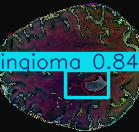

In [33]:
# Assuming `new_results` contains your detection results from a YOLO model
res_plotted = new_results[0].plot()  # Get the plotted result (image with detections)

# Convert the image from BGR (OpenCV format) to RGB (PIL format)
res_plotted = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

# Display the image using PIL's Image module
display(Image.fromarray(res_plotted))